# Filtro pasa altas en Fourier (image sharpening)

Ya sabemos que una imagen puede ser suavizada al atenuar los componentes en alta frecuencia de la transformada de Fourier. Debido a que los bordes y otros cambios abruptos de intensidad están asociados con los componentes en alta frecuencia, el sharpening de una imagen puede ser conseguido en el dominio de la frecuencia mediante un **filtro pasaaltas**, el cual atenúa los componentes en bajas frecuencias sin afectar a la información en alta frecuencia en la DFT.

Dado que un filtro pasaaltas es básicamente el complemento de un filtro pasabajas, podemos obtener un *filtro pasaaltas* mediante:

$$ H_{HP}(u, v) = 1 - H_{LP}(u, v)$$

En donde $H_{LP}$ es la función de transferencia de un filtro pasabajas, esto es, cuando un filtro pasabajas atenúa frecuencias, el filtro pasaaltas las deja pasar y viceversa.



## Filtro pasaaltas ideal

Un filtro 2D pasaaltas ideal está definido como:
$$
H(u, v) = 
\begin{cases}
    0, & \text{if} \; D(u, v) \leq D_0\\
    1, & \text{if} \; D(u, v) > D_0
\end{cases}
$$
    
A continuación se mostrará la implamentación de este filtro.

In [1]:
#cargamos librerías para operar, mostrar y cargar imágenes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def rgb2gray(image):
    """función para convertir una imagen de 3 canales (rgb) a escala de grises (1 canal)"""
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

def showImage(image, title):
    """función para mostrar las imágenes"""
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

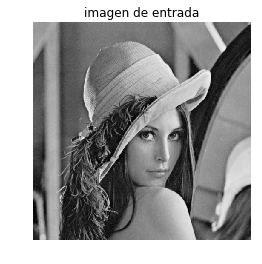

In [3]:
f = mpimg.imread('Lenna.PNG')
f = rgb2gray(f)

showImage(f, 'imagen de entrada')

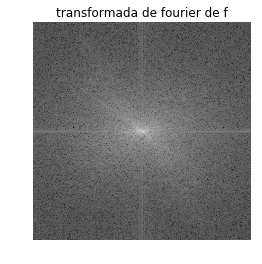

In [4]:
fourier = np.fft.fft2(f) #transformada de fourier
fourier = np.fft.fftshift(fourier) #centrar el componente dc de frecuencia

#mostramos solo la parte real, y aplicamos la transformada logaritmo para poder contraer el acontraste de la imagen
showImage(np.real(np.log(1 + fourier)), 'transformada de fourier de f')

Ahora pasaremos a generar el filtro pasa altas ideal, que consistirá en un circulo donde los elementos que se encuentren fuera de este valdrán 1 y en el interior 0, para solo quedarnos con las frecuencias altas.

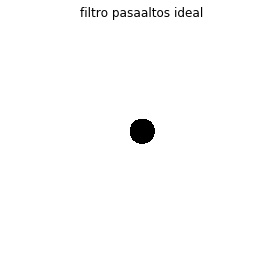

In [5]:
pasaaltos_ideal = np.ones(fourier.shape)
sizeX, sizeY = pasaaltos_ideal.shape
D = 30 #radio del circulo

for i in range(sizeX):
    for j in range(sizeY):
        if((i - sizeX//2)**2 + (j - sizeY//2)**2) < D**2:
            #solo a aquellas posiciones que estén dentro del circulo valdrán 0
            pasaaltos_ideal[i, j] = 0

showImage(pasaaltos_ideal, 'filtro pasaaltos ideal')


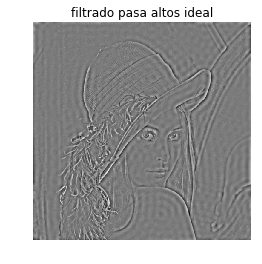

In [6]:
filtered_ideal = pasaaltos_ideal * fourier
filtered_ideal = np.fft.ifftshift(filtered_ideal)
filtered_ideal = np.fft.ifft2(filtered_ideal)
filtered_ideal = np.real(filtered_ideal)

showImage(filtered_ideal, 'filtrado pasa altos ideal')



## Filtro pasa altos Butterworth
Un filtro Butterworth 2D pasa altos de orden $n$ y con una frecuencia de corte $D_0$ está definido como:

$$H(u, v) = \frac{1}{1 + [D_0/D(u, v)]^{2n}}$$

A continuación veremos la implementación de este filtro.

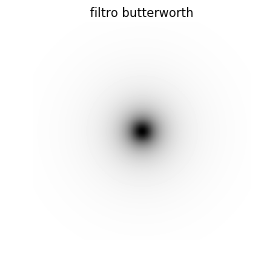

In [7]:
butterworth = np.zeros(f.shape)
D0 = 30
n = 2 * 1

for i in range(sizeX):
    for j in range(sizeY):
        Duv = ((i - sizeX//2)**2 + (j - sizeY//2)**2)**0.5 
        butterworth[i, j] = 1/(1 + (D0/(Duv+0.0001))**(n))

showImage(butterworth, 'filtro butterworth')

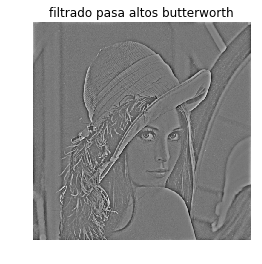

In [8]:
filtered_butter = butterworth * fourier
filtered_butter = np.fft.ifftshift(filtered_butter)
filtered_butter = np.fft.ifft2(filtered_butter)
filtered_butter = np.real(filtered_butter)

showImage(filtered_butter, 'filtrado pasa altos butterworth')


## Filtro pasa altos gaussiano

La función de transferencia de un filtro gaussiano pasa altos con una frecuencia de corte localizado a una distancia $D_0$ desde el centro del rectángulo está dado por:

$$ H(u, v) = 1 - e^{-D^2(u, v)/2D_0^2}$$

A continuación la implementación


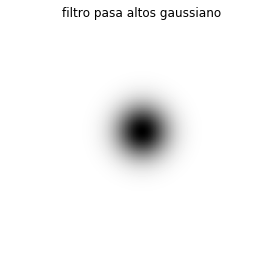

In [9]:
gaussian = np.zeros(f.shape)
D0 = (2 * 30)**2  #frecuencia de corte, el 2 es para no multiplicarlo en cada iteración, seggún la formula

for i in range(sizeX):
    for j in range(sizeY):
        Duv = ((i - sizeX//2)**2 + (j - sizeY//2)**2)
        gaussian[i, j] = 1 - np.exp(-1*Duv/D0)

showImage(gaussian, 'filtro pasa altos gaussiano')



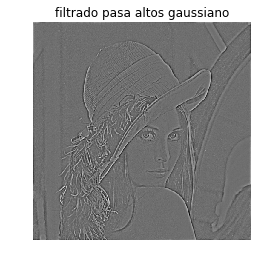

In [10]:
filtered_gaussian = gaussian * fourier
filtered_gaussian = np.fft.ifftshift(filtered_gaussian)
filtered_gaussian = np.fft.ifft2(filtered_gaussian)
filtered_gaussian = np.real(filtered_gaussian)

showImage(filtered_gaussian, 'filtrado pasa altos gaussiano')

## El Laplaciano en el dominio de la frecuencia

El laplaciano puede ser implementado en el dominio de la frecuencia usando el filtro:

$$H(u, v) = -4 \pi ^2(u^2 + v^2)$$

O, respecto al centro del rectángulo de frecuencias, usando el filtro:

$$H(u, v) = -4 \pi ^2 D^2(u, v)$$

En donde $D(u, v)$ es la distancia al centro, por lo que la imagen del laplaciano se obtiene como:

$$\nabla ^2f(x, y) = \mathfrak{F}^{-1} \{H(u, v)G(u, v) \} $$

En donde $F(u, v)$ es la DFT de $f(x, y)$.

La mejora de la imagen se logra usando la ecuación:

$$g(x, y) = f(x, y) + c \nabla ^2f(x, y)$$

En donde $c = -1$ ya que $H(u, v)$ es negativo.

El calcular $\nabla^2f(x, y)$ introduce factores de escalamiento en la DFT que son mayores en orden de magnitud que el máximo valo de $f$. Por lo tanto, las diferencias entre $f$ y su laplaciano deben de ponerse en rangos similares. La manera más sencilla de lograrlo es normalizar los valores de $f(x, y)$ a un rango de $[0, 1]$ (antes de calcular la DFT) y dividir $\nabla ^2f(x, y)$por su máximo valor, lo cual hará que los valores se encuentren en un rango de $[-1, 1]$ (el laplaciano tiene valores negativos). Por lo que la mejora de la imagen se calcula de la siguiente manera:

$$g(x, y) = \mathfrak{F}^{-1} \{ F(u, v) - H(u, v)F(u, v) \} $$

$$ = \mathfrak{F} ^{-1} \{[1 - H(u, v)] \} $$

$$ = \mathfrak{F} ^{-1} \{ [1 + 4 \pi ^2D^2(u, v)] F(u, v) \}$$

Veamos la implementación del laplaciano.

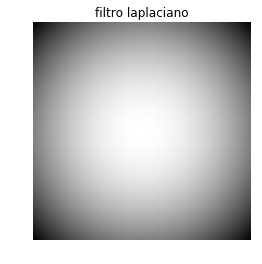

In [11]:
laplaciano = np.zeros(fourier.shape)

for i in range(sizeX):
    for j in range(sizeY):
        Duv = ((i - sizeX//2)**2 + (j - sizeY//2)**2)
        laplaciano[i, j] = -4 * (np.pi)**2 * Duv

showImage(laplaciano, 'filtro laplaciano')


Ahora obtenemos $\nabla ^2 f(x, y) = \mathfrak{F}^{-1} \{H(u,v)F(u, v) \}$

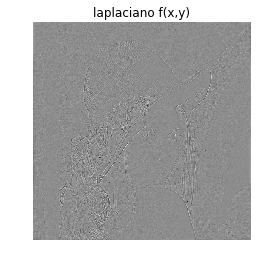

In [12]:
filtered_laplacian = laplaciano * fourier
filtered_laplacian = np.fft.ifftshift(filtered_laplacian)
filtered_laplacian = np.fft.ifft2(filtered_laplacian)
filtered_laplacian = np.real(filtered_laplacian)

showImage(filtered_laplacian, 'laplaciano f(x,y)')

Para poder realizar la operación: 
$$ g(x, y) = f(x, y) + c \nabla ^2 f(x, y)$$
debemos normalizar el valor de f(x, y) = $[0, 1]$
normalizar el valor de $\nabla ^2 f(x, y)$ = $[-1, -1]$
con $c = -1$

rango del laplaciano:  -1.228021566477707 1.0
rango de la imagen f:  0.09758862888030709 0.9607682376265525


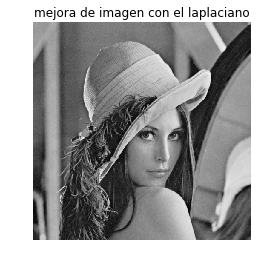

In [13]:
filtered_laplacian = filtered_laplacian/np.max(filtered_laplacian)

print('rango del laplaciano: ',np.min(filtered_laplacian), np.max(filtered_laplacian)) 
print('rango de la imagen f: ', np.min(f), np.max(f))

c = -0.05
g_laplaciano = f + c*filtered_laplacian

showImage(g_laplaciano, 'mejora de imagen con el laplaciano')


## Filtrado homomórfico

Una imagen $f(x, y)$ puede ser expresada como el producto de sus componentes de iluminación $i(x, y)$ y su reflectancia $r(x, y)$, de la siguiente forma:

$$f(x, y) = i(x, y)r(x, y)$$

Esta ecuación no puede ser utilizada directamente para operar con los componentes frecuenciales de iluminación y reflectancia, debido a que la transformada de Fourier de un producto no es la suma de sus transformadas: 

$$\mathfrak{F} [f(x, y)] \neq \mathfrak{F}[i(x, y)] \mathfrak{F}[r(x, y)] $$

Sin embargo, supongamos que definimos:

$$ z(x, y) = \text{ln} \; f(x,y) $$
$$= \text{ln} \; i(x,y) + \text{ln} \; r(x,y)$$

Entonces,

$$ \mathfrak{F} \{ z(x, y) \} = \mathfrak{F} \{ \text{ln} \; f(x, y) \}$$

$$ = \mathfrak{F} \{ \text{ln} \; i(x, y) \ + \mathfrak{F} \{ \text{ln} \; r(x, y) \} $$

Es decir:

$$Z(u, v) = F_i(u, v) + F_r(u, v) $$

Es así que podemos filtrar $Z(u, v)$ usando un filtro $H(u, v)$ de tal manera que: 

$$ S(u, v) = H(u, v) Z(u, v) $$
$$ S(u, v) = H(u, v) F_i(u, v) + H(u, v) F_r(u, v) $$

La imagen filtrada en el dominio espacial es:

$$ s(x, y) = \mathfrak{F}^{-1} \{ S(u, v) \} $$
$$ s(x, y) = \mathfrak{F}^{-1} \{ H(u, v) F_i(u, v)\} + \mathfrak{F}^{-1} \{ H(u, v) F_i(u, v)\} $$

si hacemos $i'(x, y) = \mathfrak{F}^{-1} \{ H(u, v) F_i(u, v)\} $ y $r'(x, y) = \mathfrak{F}^{-1} \{ H(u, v) F_r(u, v)\}$, entonces podemos expresar la imagen como:

$$s(x, y) = i'(x, y) + r'(x, y)$$

Finalmente, debido a que $z(x, y)$ fue formado al tomar el logaritmo naturlal de la imagen de entrada, para obtener la imagen de salida realizamos el proceso inverso que es obtener la exponencial de la imagen filtrada resultante.

$$ g(x, y) = e^{s(x, y)} $$
$$ g(x, y) = e^{i'(x, y)}e^{r'(x, y)}$$
$$ g(x, y) = i_0(x, y)r_0(x, y) $$

En donde $i_0(x, y) = e^{i'(x,y)}$ y $r_0(x, y) = e^{r'(x,y)}$ son los componentes de salida de iluminación y reflectancia de la imagen de salida.

---

El componente de iluminación de una imagen normalmente está caracterizado por lentas variaciones espaciales, mientras que los componentes de reflectancia tienden a variar abruptamente, particularmente en las uniones de objetos que no son similares. Estas caracteristicas permiten asociar las bajas frecuencias de la transformada de Fourier con el logaritmo de una imagen con iluminación y las altas frecuencias con la reflectancia. Lo cierto es que estas asociaciones son un poco al tanteo, pero sirven para mejorar la imagen.

Una buena manera de controlar las componentes de iluminación y reflectancia

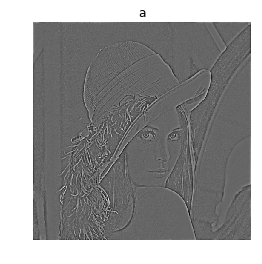

In [14]:
#si algún elemento de la matriz es cero, debo de sumar 1. Lo haré después.
z = f.astype('double')
z = np.log(1 + z)

z = np.fft.fft2(z)
h = np.fft.fftshift(gaussian)

filter_homomorphic = z * h
filter_homomorphic = np.real(np.fft.ifft2(filter_homomorphic))
filter_homomorphic = np.exp(filter_homomorphic) - 1

showImage(filter_homomorphic, 'a')
